In [8]:
import numpy as np
import seaborn as sns

# Word embeddings
A quick look into the structure of some popular word embeddings.

Is there any obvious surface difference in their encodings? Is there any practical difference (or similarity!) on some toy test domains?

In [1]:
def load_embedding_text(input_file):
    """ loads text embedding as mapping word => POS=> list of values """
    embedding = {} 
    with open(input_file) as in_file:
        for line in in_file:
            tokens = line.strip().split(' ')
            if len(tokens) > 10:
              word = tokens[0].split('_')[0]
              if not word in embedding:
                  embedding[word] = {}
              embedding[word][tokens[0].split("_")[1]] = [float(v) for v in tokens[1:]]
    return embedding

Load two embeddings to work with: 

- **British National Corpus**: using window size 10
- **English Wikipedia**: using window size 5

In [57]:
bnc = load_embedding_text("/media/jono/Data/workspace/corpora/word-embedding/BNC/model.txt")
wiki = load_embedding_text("/media/jono/Data/workspace/corpora/word-embedding/Wiki/model.txt")

Initially we'll work with British National Corpus, then later compare the two.

In [5]:
print([pos for pos in bnc["time"]])

['NOUN', 'VERB', 'X']


In [10]:
print(len(bnc["time"]["NOUN"]))
print(bnc["time"]["NOUN"][:5])

300
[0.028551, -0.088598, 0.050082, 0.007181, -0.104172]


Seems to have loaded up ok.

## Check individual words' embeddings
As a starter, let's take a look at the values of all dimensions in one plot.

We'll start by comparing "time" verb with "time" noun:

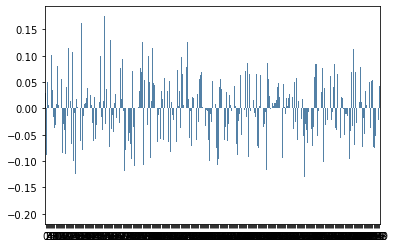

In [14]:
sns.barplot(x=list(range(0,300)),y=bnc["time"]["NOUN"],color="steelblue")

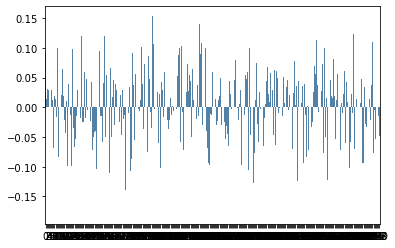

In [15]:
sns.barplot(x=list(range(0,300)),y=bnc["time"]["VERB"],color="steelblue")

Clearly quite different, but with 300 dimensions it's hard to see whether or not there are similarities in any specific dimensions.

## Check pair-wise differences
Let's measure the difference (dot product) and also plot the similarity and difference per dimension.

In [19]:
np.dot( bnc["time"]["NOUN"], bnc["time"]["VERB"] )

0.5910477729190002

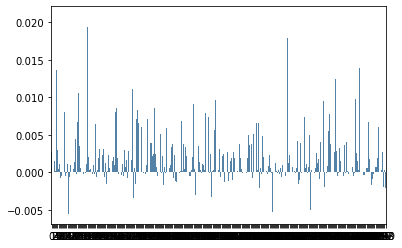

In [23]:
sns.barplot(x=list(range(300)), y=np.multiply( bnc["time"]["NOUN"], bnc["time"]["VERB"]), color="steelblue")

This is more informative. It appears the signs are fairly consistent, even if magnitudes differ in each dimension.

### Extreme word pairs

Now find something that should be very similar. Notably there are entries for "time/distance" and "distance/time", I bet these are similar:

0.7711871510770008


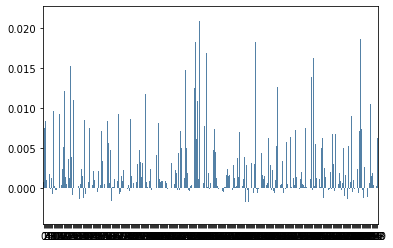

In [25]:
print(np.dot( bnc["time/distance"]["X"], bnc["distance/time"]["X"] ))
sns.barplot(x=list(range(300)), y=np.multiply( bnc["time/distance"]["X"], bnc["distance/time"]["X"]), color="steelblue")

## Understanding dimensions

In each dimension we can look for one or two prototypical words. Using words with maximal (and minimal) value in each dimension should give a fair approximation of a "canonical" meaning for the dimension.

In [50]:
def prototypical(embedding, dim, top_n=300):
    ws = [ (w,pos,embedding[w][pos][dim]) for w in embedding for pos in embedding[w]  ]
    ws.sort(key=lambda x: x[2])
    if top_n < len(ws):
        return ws[-top_n//2:] + ws[:top_n//2+1]
    return ws
print(prototypical(bnc,0,top_n=5))

[('amenable', 'ADJ', -0.19621), ('plumbing', 'NOUN', -0.192484), ('planter', 'NOUN', -0.191131), ('crash', 'NOUN', 0.18644), ('collide', 'VERB', 0.190083), ('oil', 'NOUN', 0.201998)]


One of the less interesting dimensions: it represents something shared by "oil" and "collide", not found in "amenable" and "plumber".

Let's get the top-5 for each dimension, then only look at the dimensions with strong prototypes (i.e. high magnitude representative word)

In [54]:
representatives = [ (i,prototypical(bnc,i,top_n=5)[:10]) for i in range(300) ]
representatives.sort(key=lambda x: -max(abs(x[1][0][2]),abs(x[1][-1][2])))

In [55]:
print("\n".join( [str(dim)+":\t" +", ".join([r[0]+"("+str(r[2])+")" for r in rs]) for dim,rs in representatives[:10]]))

1:	pulsation(-0.184412), I.(-0.184411), ambivalent(-0.174861), Pcx(0.290951), kitchenware(0.301665), shredder(0.335624)
4:	Babyliss(-0.332363), s1000(-0.32804), paintbrush(-0.325649), Bellarmine(0.203163), contemporaneous(0.207667), Durkheim(0.224539)
140:	fondle(-0.165612), Guatemala(-0.163899), doc(-0.15232), ncp7::mutant(0.320939), fe(iii)(0.321093), proviral::dna(0.323331)
53:	honeycomb(-0.163532), loci(-0.158405), atrocity(-0.158182), Sterland(0.28224), equalizer(0.291655), kitty(0.313236)
2:	definitive(-0.17747), nazi-soviet::pact(-0.16574), Vesuvius(-0.162604), Yamaha(0.289657), £1,300(0.291861), Knitmaster(0.311133)
284:	chun(-0.310383), woo(-0.307985), Fernand(-0.303047), actuarial(0.154717), peptic::ulcer(0.159847), underwriting(0.172422)
176:	alligator(-0.310338), cavern(-0.293397), racist(-0.285117), bishopric(0.185003), albret(0.192026), 1460s(0.202326)
73:	Maggiore(-0.30637), Taormina(-0.304155), Sant'(-0.287795), Porter(0.181154), Htv(0.191689), spitting(0.203135)
142:	K

Some possiblities by dimension:
 - 1: kitchen hardware
 - 140: scientific: chemisty/DNA
 - 53: football, possibly sports betting
 - 284 and 73: NOT non-English names
 -  176: NOT cave/adventure?, (historical?)
 - 2: shopping products
 - 142: scientific: geology
 - 222: NOT scientists, scientific roles, (shopping listings)

We could test these by checking the values in each dimension of a word we consider similar. Probably not too important.

Let's see what turns up from the Wikipedia embedding as a comparison:

In [58]:
wiki_representatives = [ (i,prototypical(wiki,i,top_n=5)[:10]) for i in range(300) ]
wiki_representatives.sort(key=lambda x: -max(abs(x[1][0][2]),abs(x[1][-1][2])))

In [59]:
print("\n".join( [str(dim)+":\t" +", ".join([r[0]+"("+str(r[2])+")" for r in rs]) for dim,rs in wiki_representatives[:10]]))

56:	Maghi(-0.322271), Nuakhai(-0.314302), Tantras(-0.302305), rain-soaked(0.199354), John::Hopkins(0.209959), Frank::Whittle(0.218923)
230:	32.50(-0.202763), Ludi(-0.200148), brutally(-0.197476), Palomares(0.244829), Rocketdyne(0.270664), Aerojet(0.320937)
189:	Franklinton(-0.202248), ERA(-0.192199), Anti(-0.190796), exacerbation(0.313147), three-month(0.317438), preoperative(0.319877)
74:	THB(-0.317197), Gringos(-0.313345), NGL(-0.291504), R.B.(0.181367), General::Store(0.185738), Eleventh(0.188016)
151:	Vanzetti(-0.187529), United::States::Tax::Court(-0.182782), voter(-0.179898), Royal::Prince::Alfred::Hospital(0.298311), Foxdale(0.307412), Stacey::Jones(0.310668)
13:	Cia(-0.20555), feg(-0.197762), vivax(-0.18924), Hickory::Hill(0.275049), Burris(0.289937), hardscrabble(0.309772)
190:	LXIII(-0.186537), Fort::Chaffee(-0.175775), 2084(-0.175399), ritualism(0.295135), Christendom(0.298519), Liberal::Catholic::Church(0.305788)
277:	whig(-0.305711), Heneage::Finch(-0.304941), Earl::Russel

The change in domain (to encyclopaedia) is probably more significant than the change in window size (to more local: 5 words). There are a lot of proper nouns turning up:
- 56: NOT South Asian festivals, holy days
- 230: rocket or aircraft propulsion
- 189: medical diagnosis?
- 151: How did Stacey Jones get in there?! Definitely more international than BNC corpus
- 190: religion, christianity
- 277: English political history (whigs)
- 2: Notable actor/musicians/historical figures (NOT geology)
- 278: (NOT numeric ranges)

This is definitely less clear, it seems each dimension is putting in more work and meaning will probably only fall out from combinations of dimensions.

## Comparing embeddings

Rather than comparing two embeddings across their full set of dimensions or full word lists, we can instead consider how they behave over a small word set.

The easist tool is to use the dot product of the embedded words as a similarity metric (as we did earlier). Some ways this could be used:
- cluster words by similarity
- produce a graph of words with edges weighted by similarity
- produce a graph of the dimensions with edges weighted by mutual value across all words

I'll take a small set of (26) nouns. One for each letter of the alphabet so we can draw a graph with easily understandable node labels.

In [64]:
language = ['apple','bastion','clipboard','dynamite','eagle','fern','greyhound','helicopter','integral','justice','kite','language','model','nightmare','oval','picture','quest','rotunda','stadium','tornado','unit','vestibule','wonder','xylophone','yacht','zoo']
print( all(w in wiki and w in bnc for w in language))

True


In [95]:
def similarity(a,b,embedding):
    return np.dot(embedding[a]["NOUN"],embedding[b]["NOUN"])

def word_graph(language, embedding):
    adj_matrix = [[1.0-similarity(a,b,embedding) for a in language] for b in language]
    # find the mean of the differences: we'll pretend there are no edges above it
    mean = sum(np.mean(np.absolute(row)) for row in adj_matrix) / len(adj_matrix)
    print("Mean word distance:",mean)
    # NOTE: I've thrown in a weighting towards 0.7 to eliminate some more edges: it was too dense with mean cutoff
    return {x[0:3]: {y[0:3]: adj_matrix[i][j] for j,y in enumerate(language) if i != j and adj_matrix[i][j] < (mean+0.7)/2} for i,x in enumerate(language)}
    

In [96]:
import pygraphviz as pgv
from IPython.display import Image

g = pgv.AGraph( word_graph(language, bnc) )

Mean word distance: 0.7795324295979852


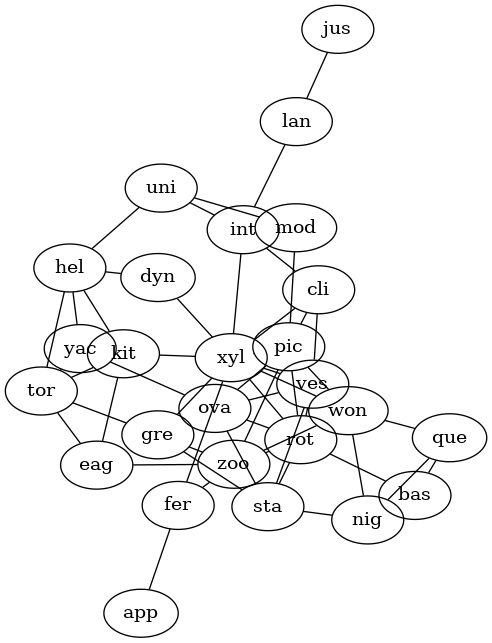

In [97]:
Image(g.draw(format='png', prog='neato'))

It's nice to see eagle+kite close together, and then kite+yacht, then yacht+tornado (even if not explicitly connected). 

Abstract concepts like justice and language sit off integral. No idea why apply is on its own, however.

Next up, wikipedia:

Mean word distance: 0.8082947273262987


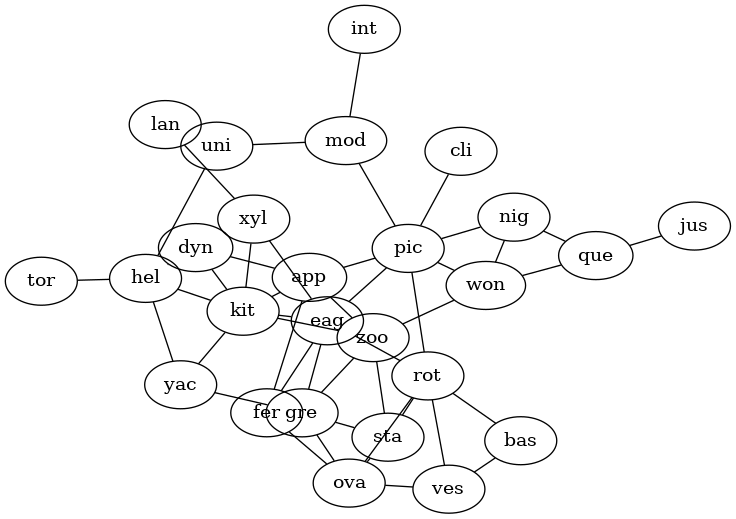

In [98]:
g2 = pgv.AGraph( word_graph(language, wiki) )
Image(g2.draw(format='png', prog='neato'))

The kite/eagle/yacht cluster holds, with tornado off the side. Helicopter hovers around this too, which is the same in the BNC embedding.

Justice now sits off question instead, but these abstract concepts are still on the edges.

Apple is now a core term (no pun intended, but certainly welcomed), connecting up to picture, dynamite, fern, kite and zoo whereas BNC only had a strong connection to fern. 

## Initial thoughts

The embeddings are doing very different things with their dimensions -- probably a domain specific feature. However, on a shared vocabulary the overall embedding space isn't surprisingly similar.

There is definitely some diversity. In practice, using multiple embeddings built on different data (even just sampled data) as an ensemble is worth considering.

In a DNN an ensemble of pre-trained embeddings could easily be incorporated by just expanding the initial layer, concatenating the features. This would be much more efficient than ensembling the whole thing, especially if the embedding layers are fixed or frozen for training.

Note to self: dig in to this some time.